<div> 
 <div align="left"> <img src="JO_LOGO.gif" width="500" height="500" align="left">  </div>
 <div> <h1> <br/> <br/> <br/> <br/> Project: Image Reader </h1> </div>
</div>

------------------------------------------------------------------------------
------------------------------------------------------------------------------

<div align="left"> <img src="ProjectOverview.jpeg" width="200" height="200" align="left"> </div>
<div> <p align="right"> <h3> <br><br><br><br>Project Overview </h3> </p> </div>

The main objective of the startup is to build a new mobile document digitization experience for the blind. The problem to be solved in this project is to identify if book images contain flipped pages or not. The company intends to use these labeled images as input for another machine learning model. 
This project's goal is to build a machine learning model that can label the book images as 'flip' or 'not flip'.

----------------------------------------------------------------------------------------------

<div> 
    <div align="left"><img src="data.png" width="50" height="50" align="left">
    </div>
    <div >
        <p align="left"><h4><br>Data source Overview</h4> </p>
    </div>
</div>

The data belongs to an organization which develops innovative Artificial Intelligence and Computer Vision solutions. The data provided contains images labelled as 'flip' and 'not flip'. The dataset contains 

    | | Dataset type  | Total Records #    | Flip count #   | Not flip count #   |
|---:|:-------------|:-----------|:------|:------|
| 1 | Train Dataset  | 2392       | 1162   | 1230     |
| 2 | Test Dataset  | 597    | 290   | 307     |


----------------------------------------------------------------------------------------------

<html>
    <div align="left"><img src="config.gif" width="50" height="50" align="left">
    </div>
     <div align="left">
         <h3><br>Initial Setup </h3>
    </div>
</html>

 - ###### Import all the required libraries

In [1]:
# Import the required Libraries
import os
import math
import random
import copy
import warnings
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from pathlib import Path
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace
from torchvision.utils import make_grid
import torch.nn.functional as F

 - ###### Set the random seed and image folder path

In [2]:
# Set the file path
data_train_path=os.path.join(os.path.abspath('') , "Data","images","training")
data_test_path=os.path.join(os.path.abspath('') , "Data","images","testing")
# Set the random seed
random_seed=1212

# Set the random seed for python environment 
os.environ['PYTHONHASHSEED']=str(random_seed)

# Set numpy random seed
np.random.seed(random_seed)

# Set the random seed value
random.seed(random_seed)

# set the torch and cuda random seed
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)


# Setup List for storing the classfier, accuracy, f1 score and datatset type
eval_report=list()
# Filter out the warnings
warnings.filterwarnings('ignore')

# The flag below controls whether to allow TF32 on matmul. This flag defaults to True.
torch.backends.cuda.matmul.allow_tf32 = False

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = False

Computation device: cuda:0


In [3]:
# set computation device to cuda after checking it's available
_DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {_DEVICE}")
_DEVICE_2 = 'cpu'

# Bath sizes 
_BATCH_SIZE = 16

# Clear the cuda cache
torch.cuda.empty_cache()

 - ###### Define functions and Classes

In [48]:
# Load the files from sub directories   IterableDataset
class img_DataSet(torch.utils.data.Dataset):
    
    '''
    img_DataSet class will return the an IterableDataset 
    for images located in a folder
    '''
    # define the image path
    def __init__ (self, strBasePath ):
        self.basePath = strBasePath
        self.labels = []
        self.file_names = []
        self.file_path = []
        self.statDict = {}
        self.statDict['Total_Count'] = 0
        self.statDict['Flip_Img_Count'] = 0
        self.statDict['Not_Flip_Img_Count'] = 0
    
    def get_lbl_filePath(self):
        '''
        iterate through the folders and fetch info
        about file paths and labels 
        '''
        # create a path object
        strPath = Path(self.basePath)
        
        # iterate through the current directory and subdirectories
        for curDir, subDir, fileNames in os.walk(strPath, topdown=True):
            # Loop throught the files
            for file in fileNames:
                # append the file names and path fetch the labels 
                self.file_names.append(file)
                str_path = os.path.join(curDir, file)
                self.file_path.append(str_path)
                self.labels.append(str_path.split("\\")[-2].lower())
                
    # Get the dimension
    def get_dimensions(self ):
        '''generate report on record info'''
        self.statDict['Total_Count']  = len(self.labels)
        self.statDict['Flip_Img_Count'] = np.sum(np.sum([item == "flip" for item in self.labels]))
        self.statDict['Not_Flip_Img_Count'] =  self.statDict['Total_Count']  - self.statDict['Flip_Img_Count']
        print("#################################################################")
        print(" Total number of images found : ", self.statDict['Total_Count'] )
        print(" Total number of flip images in dataset : ", self.statDict['Flip_Img_Count'])
        print(" Total number of notflip images in dataset: ", self.statDict['Not_Flip_Img_Count'])
        print("#################################################################")
    
    def pre_process_ds(self, info=True, crop=False, Size=300 ):
        '''
        Generate the report and the load the 
        images dataset into pytorch image data set format
        and return it 
        '''
        # check if info is needed 
        if (info):
            # create the label 
            self.get_lbl_filePath()
            self.get_dimensions()
       
        # Check if cropping id needed  transforms.Resize(Size+100),
        if (crop == True):
             transform = transforms.Compose([ transforms.CenterCrop(Size),
                                        transforms.Scale(300),
                                        transforms.ToTensor()])
        else:
            transform = transforms.Compose([  transforms.ToTensor()])
            
        # load the Data set
        image_datasets = datasets.ImageFolder(self.basePath, 
                                              transform)                              
        # return the dataset
        return image_datasets

# Class for implementing LR scheduler
class LRScheduler():
    """
    This class will be used in implementing Reduce LR On Plateau Scheduler
    for adjusting the learning rate during training process. If the validation
    loss does not increase in given no of epochs, then learning rate will decrease 
    based on the factror value. 
    """
    def __ini__(self,optimizer, patience=4, min_lr =1e-5, factor=0.6):
        """
        new learning rate = old lr * factor
        patience: how many epochs to wait before changing lr 
        min_lr  : Minimum lr
        factor : factor by which lr needs to be updated
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr  = min_lr 
        self.factor = factor
        
        # Define the lr scheduler
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                                       patience=self.patience,
                                                                        min_lr =self.min_lr,
                                                                       factor= self.factor,
                                                                       verbose=True
                                                                      )
        def __call__(self, val_loss):
            self.lr_scheduler.step(val_loss)


class NeuralNetworkCNN(nn.Module):
    """
    This class is used for creating a custom CNN neural n/w for classifying the images. 
    It will consisit of 4 conv2d layer each followed by BatchNorm2D layer, Relu activation
    ,dropout and MaxPool2d layer call. 
        Then we will be calling 3 linear fully connected layers where each linear layer is 
        calling relu activation function except the final layer which is calling LogSoftmax
        as final activation function
    """
    def __init__(self):
        '''
        define the layers of the cnn neural n/w
        '''
        super(NeuralNetworkCNN, self).__init__()
        self.Conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=2),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Dropout2d(p=0.1)
        )
        self.Conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Dropout2d(p=0.1)
        )
        self.Conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Dropout2d(p=0.1)
        )
        self.Conv_final = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=2, padding=0),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Dropout2d(p=0.1)
        )

        self.fc1 =  nn.Sequential(
                    nn.Linear(16 * 17 * 17, 256),
                    nn.ReLU(),
                    nn.Dropout2d(p=0.1))
        self.fc2 =  nn.Sequential(
                    nn.Linear(256, 84),
                    nn.ReLU())
        self.fc3 =  nn.Linear(84, 2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.softmax = nn.LogSoftmax(dim=1)
   
    def forward(self, x):
        '''
        initialize the neural n/w model
        '''
        x = self.Conv_1(x)
        x = self.maxpool(x)
        x = self.Conv_2(x)
        x = self.maxpool(x)
        x = self.Conv_3(x)
        x = self.maxpool(x)
        x = self.Conv_final(x) 
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        # follow same convention
        x = self.softmax(self.fc3(x))
        return x
   
    
def binary_acc(y_pred, y_test):
    ''' binary_acc: It will predict the accuracy of prediction 
    done by model.
    Input parameters:
    y_pred : predicted labels 
    y_test : expected labels 
    
    output: Returns how many percentage of labels were correctly predicted
    '''
    #set_trace()
    correct_results_sum = ( torch.argmax(y_pred, dim=1) == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc


# function 1
def visualize_images_DS (img_Ds):
    ''' visualize_images_DS:
    Input: 
    This function takes torch.utils.data.Dataset object as input 
    lstSentences: torch.utils.data.Dataset of images 
    Output:
    This function displays three images randomly from dataset and 
    shows their size and lable info
    '''
    # Define the label mapping
    labels_map = {
        0: "Flip",
        1: "Not Flip"
    }

    # Define image size
    figure = plt.figure(figsize=(8, 8))

    cols, rows = 3, 1
    for i in range(1, cols * rows + 1):
        # Randomly select the id's
        sample_idx = torch.randint(len(img_Ds), size=(1,)).item()
        # Fetch image and label for random id
        img, label = img_Ds[sample_idx]
        # Print image info
        print("Image Shape: " , img.shape, " | Label : ",label)
        # Alter the image shape 
        img1 = img.squeeze().permute(1,2,0)
        # add the subplots
        figure.add_subplot(rows, cols, i)
        # Set tittle
        plt.title(labels_map[label])
        plt.axis("off")
        # Show image
        plt.imshow(img1)
    # Show the image
    plt.show()
    
def mili_sec_minutes_sec(flt_milisec):
    """
    Takes time in mili seconds as inout and returns it into 
    h:m:s
    """
    millis = int(flt_milisec)
    seconds=(millis/1000)%60
    seconds = int(seconds)
    minutes=(millis/(1000*60))%60
    minutes = int(minutes)
    hours=(millis/(1000*60*60))%24
    str_time_stamp = "%d:%d:%d" % (hours, minutes, seconds)
    return str_time_stamp

#Plotting loss for all epochs
def plot_line_lots( x_list, y_dict ):
    """
    This function will plot multiple line plots. It will
    take two inputs
    x_list: list containing x labels
    y_dict: y dict is a dictionary object containing lists and their names
        for line plot
    """
    plt.figure(figsize=(8,8))
    for name, item in y_dict.items():
        plt.plot(x_list, item, label=name)
    plt.xlabel("No of Epochs")
    plt.legend()
    plt.show()

 - ###### Load the images data

In [5]:
print("Loading Training images !! ")
# Create class instance for train 
cls_training_ds_loader = img_DataSet(data_train_path)
train_img_Ds = cls_training_ds_loader.pre_process_ds(info = True)
# Load the training dataset
trainloader = torch.utils.data.DataLoader(train_img_Ds, 
                                          batch_size=_BATCH_SIZE, 
                                          shuffle=True)
print("Loading Test images !! ")
# Create class instance for testing 
cls_test_ds_loader = img_DataSet(data_test_path)
test_img_Ds = cls_test_ds_loader.pre_process_ds(info = True)
# Load the training dataset
testloader = torch.utils.data.DataLoader(test_img_Ds, 
                                          batch_size=_BATCH_SIZE, 
                                          shuffle=True)

Loading Training images !! 
#################################################################
 Total number of images found :  2392
 Total number of flip images in dataset :  1162
 Total number of notflip images in dataset:  1230
#################################################################
Loading Test images !! 
#################################################################
 Total number of images found :  597
 Total number of flip images in dataset :  290
 Total number of notflip images in dataset:  307
#################################################################


----------------------------------------------------------------------------------------------

<div> 
    <div align="left">
        <img src="EDA.jpeg" width="250" height="250"  align="left">
    </div>
    <div>
        <p align="right"><h3><br><br><br><br>Exploratory Data Analysis</h3></p>
    </div>
</div>

 - Check for label distributions in Test and Train distribution

In [6]:
# Data 
data = {'Train':[ val for val in cls_training_ds_loader.statDict.values()], 
        'Test':[ val for val in cls_test_ds_loader.statDict.values()] }
# Check for image shapes 
df_images = pd.DataFrame(data) 
df_images.index = ['Total_Count','Flip_Img_Count','Not_Flip_Img_Count' ]

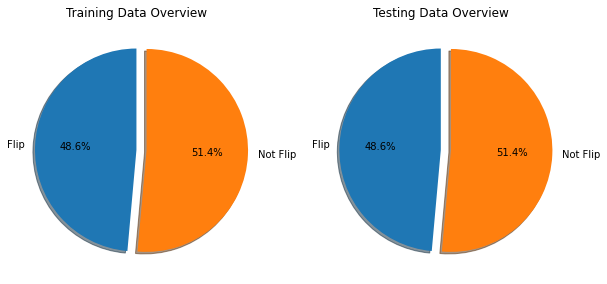

In [7]:
# Define Labels and explode
labels = ['Flip', 'Not Flip']
explode = (0, 0.1)

# Plot the pie charts 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
# Pie chart for Train dataset image distribution
ax1.pie(df_images['Train'][1:], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, explode=explode)
ax1.set_title('Training Data Overview')
# Pie chart for Test dataset image distribution
ax2.pie(df_images['Test'][1:], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, explode=explode)
ax2.set_title('Testing Data Overview')
# show the plot
plt.show()

From looking at the label distirbution, train and test dataset both almost uniform distribtution of labels.

 - Check for image size and visualize

Image Shape:  torch.Size([3, 1920, 1080])  | Label :  1
Image Shape:  torch.Size([3, 1920, 1080])  | Label :  1
Image Shape:  torch.Size([3, 1920, 1080])  | Label :  0


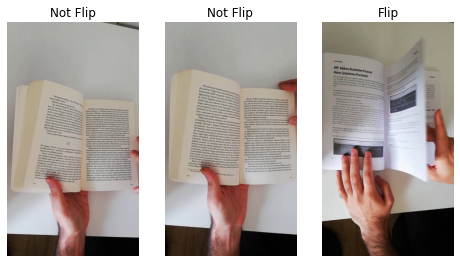

In [8]:
# Visualize Trainind images
visualize_images_DS (train_img_Ds)

Image Shape:  torch.Size([3, 1920, 1080])  | Label :  1
Image Shape:  torch.Size([3, 1920, 1080])  | Label :  0
Image Shape:  torch.Size([3, 1920, 1080])  | Label :  1


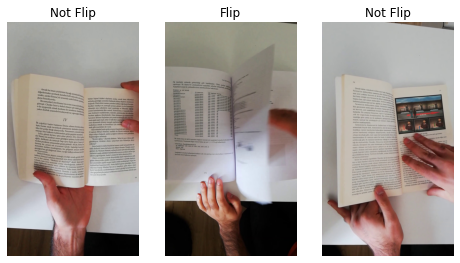

In [9]:
# Visualize test images
visualize_images_DS( test_img_Ds)

<ul>
    <p>Following are the observations from visualizing the images :</p>
    <ul style="list-style-type:square;">
        <li> The images are off focus.</li>
        <li>The images are not square shaped, which is required by neural network.</li> 
        <li>There is a lot of noise in the images.</li>
    </ul>
</ul>

 - Crop and resize images

In [10]:
print("Loading cropped and resized Training images !! ")
# Create class instance for train 
cls_training_crp = img_DataSet(data_train_path)
train_crp_img_Ds = cls_training_crp.pre_process_ds(info=False, crop=True)

# Load the training dataset
train_crp_loader = torch.utils.data.DataLoader(train_crp_img_Ds, 
                                          batch_size=_BATCH_SIZE, 
                                          shuffle=True)

print("Loading  cropped and resized  Test images !! ")
# Create class instance for testing 
cls_test_crp = img_DataSet(data_test_path)
test_crp_img_Ds = cls_test_crp.pre_process_ds(info=False, crop=True)
# Load the training dataset
test_crp_loader = torch.utils.data.DataLoader(test_crp_img_Ds, 
                                          batch_size=_BATCH_SIZE, 
                                          shuffle=True)#num_workers=16)

Loading cropped and resized Training images !! 
Loading  cropped and resized  Test images !! 


Image Shape:  torch.Size([3, 300, 300])  | Label :  1
Image Shape:  torch.Size([3, 300, 300])  | Label :  1
Image Shape:  torch.Size([3, 300, 300])  | Label :  1


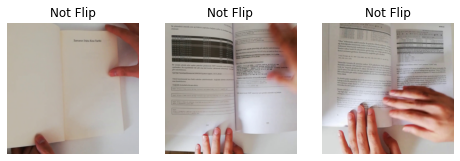

In [11]:

# Visualize train images
visualize_images_DS( train_crp_img_Ds)
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (10,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=3).permute(1,2,0))
        break
        
#show_batch(test_crp_loader)


Image Shape:  torch.Size([3, 300, 300])  | Label :  0
Image Shape:  torch.Size([3, 300, 300])  | Label :  1
Image Shape:  torch.Size([3, 300, 300])  | Label :  0


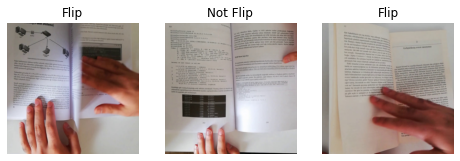

In [12]:
# Visualize test images
visualize_images_DS( test_crp_img_Ds)

----------------------------------------------------------------------------------------------

Explanation for the project 

Goal is to build a simple convolutional neural network(CNN) for classifying flip and not flipped images. <br>

##### Step 1: Input Data prep

 - Split train dataset into train and validation datasets

In [13]:
# Use test train split to shuffle the id's for train and validation datasets
training_idx, val_idx, _, _ = train_test_split(
    range(len(train_crp_img_Ds)),
    train_crp_img_Ds.targets,
    stratify=train_crp_img_Ds.targets,
    test_size=0.2,
)

# generate subset based on indices
train_split_ds = Subset(train_crp_img_Ds, training_idx)
val_split_ds = Subset(train_crp_img_Ds, val_idx)

# create batch for loading the data 
train_batches = DataLoader(train_split_ds, batch_size=_BATCH_SIZE, shuffle=True)#,num_workers=16)
val_batches = DataLoader(val_split_ds, batch_size=_BATCH_SIZE, shuffle=True)#, num_workers=16)

##### Step 2: Initialize the model and initialize config parameters
Create a class instance and initialize the model configurational parameters like optimizers to be used, leraning rate, lr schedulers.

In [182]:
# initialize the model 
model = NeuralNetworkCNN()#()


In [192]:
from torch.profiler import profile, record_function, ProfilerActivity

In [185]:
#Defining the model hyper parameters
num_epochs = 50
learning_rate = 0.03
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate , momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                          factor=0.16, patience=4, 
                                                          threshold=0.0001, 
                                                          threshold_mode='abs',min_lr=1e-5)
# Event for keeping track of time elapsed
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

##### Step 3: Train the neural network
Train the model and test it on validation dataset. The lr_scheduler(ReduceLROnPlateau) is triggered based on the loss value for validation dataset.

In [195]:
# Create lists for storing the values
epoch_train_loss = []
epoch_train_accuracy = []
epoch_val_loss = []
epoch_val_accuracy = []
# best performance 
_best_accu = 0.0
num_epochs = 2

train_instances = []

## Validation should be done after every 10 epochs
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    for epoch in range(num_epochs):

        # Start the timer
        start.record()
        print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
        #Training process begins
        train_loss_list = []
        train_acc_list = []
        model = model.to(_DEVICE)

        #Iterating over the training dataset in batches
        model.train()
        for i, (images, labels) in enumerate(train_batches):
            #Extracting images and target labels for the batch being iterated
            images = images.to(_DEVICE)
            labels = labels.to(_DEVICE)
            #Sset_trace()
            optimizer.zero_grad()
            #Calculating the model output and the cross entropy loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_acc = binary_acc(outputs, labels)

            #Updating weights according to calculated loss
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss.item())
            train_acc_list.append(train_acc.item() )

        epoch_train_loss.append(np.average(train_loss_list))
        epoch_train_accuracy.append(np.average(train_acc_list))
        print("\nAverage training loss :  {:.4f}".format(epoch_train_loss[-1]))
        print("Average training accuracy :  {:.4f}".format(epoch_train_accuracy[-1]))


        # Val_accuracyList
        val_loss_list = []
        val_acc_list = []
        # Move to eval mode

        model.eval()
        #model = model.to(_DEVICE_2)
        # Test the model on validation dataset 
        for i, (images_val, labels_val) in enumerate(val_batches):
            #Extracting images and target labels for the batch being iterated
            images_val = images_val.to(_DEVICE)
            labels_val = labels_val.to(_DEVICE)
            val_prediction =  model(images_val)
            loss_val = criterion(val_prediction, labels_val)
            val_prediction = val_prediction.to(_DEVICE_2)
            images_val = images_val.to(_DEVICE_2)
            labels_val = labels_val.to(_DEVICE_2)
            # Validation Accuracy 
            val_loss_list.append(loss_val.item())
            val_acc_list.append(binary_acc(val_prediction, labels_val))

        #Calculate the average 
        avg_val_acc = np.round(np.average(val_acc_list), 2)
        avg_val_loss = np.round(np.average(val_loss_list), 2)
        epoch_val_accuracy.append(avg_val_acc)
        epoch_val_loss.append(avg_val_loss)
        print("\nAverage validation loss :  {:.4f}".format(epoch_val_loss[-1]))
        print("Average validation accuracy :  {:.4f}".format(epoch_val_accuracy[-1]))

        # Call the lr_scheduler to adjust the lr
        lr_scheduler.step(avg_val_loss)

        # Waits for everything to finish running
        torch.cuda.synchronize()

        if avg_val_acc > _best_accu: 
            print("Saving the model best accuracy found at  epoch ",epoch)
            _best_accu = avg_val_acc
            torch.save({
                'epoch': i,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/best_model.pth')
        # Stop
        end.record()
        # Waits for everything to finish running
        torch.cuda.synchronize()
        # time for each epoch
        print("Time taken by epoch ", epoch+1 , " : (hh:mm:ss", mili_sec_minutes_sec(start.elapsed_time(end)) , ")")


Epoch 1/2: 
Average training loss :  0.1196
Average training accuracy :  95.7917

Average validation loss :  0.1000
Average validation accuracy :  96.8000
Saving the model best accuracy found at  epoch  0
Time taken by epoch  1  : (hh:mm:ss 0:2:35 )
Epoch 2/2: 
Average training loss :  0.0981
Average training accuracy :  96.5833

Average validation loss :  0.0800
Average validation accuracy :  96.9700
Saving the model best accuracy found at  epoch  1
Time taken by epoch  2  : (hh:mm:ss 0:2:39 )


In [203]:
prof.key_averages().table(sort_by="cpu_time_total", row_limit=10)

'-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  \n                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  \n-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  \nenumerate(DataLoader)#_SingleProcessDataLoaderIter._...        65.97%      206.841s        67.77%      212.457s     698.871ms     866.461ms         0.28%       87.609s     288.187ms           304  \n                                             aten::item         0.00%       8.693ms        28.95%       90.776s     149.303ms       1.488ms         0.00%      125.401s     206.252ms           608  \n   

##### Step 4: Visualize the training process
Once training is completed loss and accuracy is plotted for both training and validation datasets to understand the tarining process.

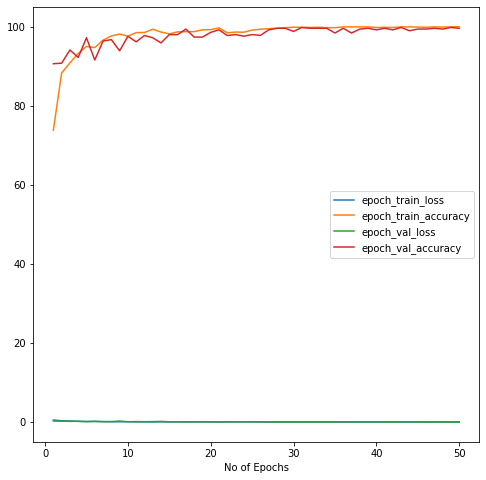

In [49]:
# Xlabels - 1 to 50 epochs
epoch_list = range(1,51)

# dictionary object containing lists of evaluation metrics for training and validation datasets
metrics_dict = { "epoch_train_loss":epoch_train_loss, "epoch_train_accuracy":epoch_train_accuracy,
                "epoch_val_loss":epoch_val_loss, "epoch_val_accuracy":epoch_val_accuracy}

# plot the graph 
plot_line_lots( epoch_list, metrics_dict)

From the plot it seens the loss values for both datasets are almost simillar. From the plot the chances of overfitting are high.

##### Step 5: Test the best model
Load the best model trained and test it.

In [66]:
# Load the best model saved during the training process
best_model = NeuralNetworkCNN()
checkpoint = torch.load("outputs/best_model.pth")

# Load the state dict vlaues
best_model.load_state_dict(checkpoint['model_state_dict'])
### now you can evaluate it
best_model.eval()


labels_test = []
predicted_lbl_test = []

# Predict for Test Dataset 
for i, (images, labels) in enumerate(test_crp_loader):
    
    predicted_values = best_model(images)
    labels_test.extend(labels)
    predicted_lbl_test.extend(predicted_values)
    print( "Accuracy for batch :", binary_acc(predicted_values, labels))
    print("Epoch " , i+1, "completed" )


Accuracy for batch : tensor(100.)
Epoch  1 completed
Accuracy for batch : tensor(100.)
Epoch  2 completed
Accuracy for batch : tensor(94.)
Epoch  3 completed
Accuracy for batch : tensor(100.)
Epoch  4 completed
Accuracy for batch : tensor(100.)
Epoch  5 completed
Accuracy for batch : tensor(100.)
Epoch  6 completed
Accuracy for batch : tensor(100.)
Epoch  7 completed
Accuracy for batch : tensor(100.)
Epoch  8 completed
Accuracy for batch : tensor(100.)
Epoch  9 completed
Accuracy for batch : tensor(100.)
Epoch  10 completed
Accuracy for batch : tensor(100.)
Epoch  11 completed
Accuracy for batch : tensor(100.)
Epoch  12 completed
Accuracy for batch : tensor(100.)
Epoch  13 completed
Accuracy for batch : tensor(100.)
Epoch  14 completed
Accuracy for batch : tensor(94.)
Epoch  15 completed
Accuracy for batch : tensor(100.)
Epoch  16 completed
Accuracy for batch : tensor(100.)
Epoch  17 completed
Accuracy for batch : tensor(100.)
Epoch  18 completed
Accuracy for batch : tensor(100.)
Epoch

In [95]:
predicted_lbl_test = [  np.argmax(pred.detach().numpy()) for pred in predicted_lbl_test ]
labels_test = [lbl.item() for lbl in labels_test]
accuracy = np.sum( predicted_lbl_test[i] == labels_test[i] for i in range(0,len(labels_test)) )/len(labels_test) 
print( "Accuracy on Test Dataset ", accuracy * 100)

Accuracy on Test Dataset  98.99497487437185


The accuracy of the model seems good on test datset as well. Let's try building an Efficienet model to see if we can achieve any better performance.

In [104]:
import torchvision.models as tv_models
from tqdm.auto import tqdm

In [148]:
def build_EfficientNet_model(pre_trained=True, fine_tune=True, number_classes=2, effinet_type=0):
    """
    This function will load a pretrained Efficient net model 
    with modified classification head
    """
    print('[INFO]: Loading pre-trained ')
    # Set the default equivalent to b0
    n_out = 1280
    # ,load the pretrained model
    if (effinet_type == 0):
        model = tv_models.efficientnet_b0(pretrained=pre_trained)
    elif (effinet_type == 1):
        model = tv_models.efficientnet_b1(pretrained=pre_trained)
    elif (effinet_type == 2):
        model = tv_models.efficientnet_b2(pretrained=pre_trained)
    elif (effinet_type == 3):
        model = tv_models.efficientnet_b3(pretrained=pre_trained)
    elif (effinet_type == 4):
        model = tv_models.efficientnet_b4(pretrained=pre_trained)
    elif (effinet_type == 5):
        model = tv_models.efficientnet_b5(pretrained=pre_trained)
        n_out = 2048
    elif (effinet_type == 6):
        model = tv_models.efficientnet_b6(pretrained=pre_trained)
    elif (effinet_type == 7):
        model = tv_models.efficientnet_b7(pretrained=pre_trained)
    else:
        model = tv_models.efficientnet_b0(pretrained=pre_trained)
    
    if fine_tune:
        print('[INFO]:  Fine tunning all layers !')
        for params in model.parameters():
            params.requires_grad = True
        # Add the final layer - Change the final classification head.
        model.classifier[1] = nn.Linear(in_features=1280, out_features=number_classes)
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers!')
        for params in model.parameters():
            params.requires_grad = False
        # Try adding more linear layers for i
        model.classifier[1] = nn.Sequential(
                      nn.Linear(n_out, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.2),
                      nn.Linear(256,256 ), 
                      nn.ReLU(), 
                      nn.Dropout(0.2),
                      nn.Linear(256, number_classes),                   
                      nn.LogSoftmax(dim=1))
    
    
    # return the model
    return model
        

In [139]:
model_eff_net = build_EfficientNet_model()
model_eff_net.to(_DEVICE)

[INFO]: Loading pre-trained 
[INFO]:  Fine tunning all layers !


EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [123]:
config_parm = checkpoint['optimizer_state_dict']['param_groups']
config_parm[0]

{'lr': 0.0048,
 'momentum': 0.9,
 'dampening': 0,
 'weight_decay': 0,
 'nesterov': False,
 'params': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21]}

In [127]:
#Defining the model hyper parameters using the config of best model 
num_epochs = 50
learning_rate = config_parm[0]['lr']
momentum =  config_parm[0]['momentum']
weight_decay = config_parm[0]['weight_decay']
nesterov = config_parm[0]['nesterov']
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate , momentum=momentum)

In [128]:
# Create lists for stroing the values
epoch_train_loss = []
epoch_train_accuracy = []
epoch_val_loss = []
epoch_val_accuracy = []
# best performance 
_best_accu = 0.0

for epoch in range(num_epochs):
    
    # Start the timer
    start.record()
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    #Training process begins
    train_loss_list = []
    train_acc_list = []
    
    #Iterating over the training dataset in batches
    model_eff_net.train()
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(train_batches), total=len(train_batches)):
        #for i, (images, labels) in enumerate(train_batches):
            #Extracting images and target labels for the batch being iterated
            images = images.to(_DEVICE)
            labels = labels.to(_DEVICE)
            #Sset_trace()
            optimizer.zero_grad()
            #Calculating the model output and the cross entropy loss
            outputs = model_eff_net(images)
            loss = criterion(outputs, labels)
            train_acc = binary_acc(outputs, labels)

            #Updating weights according to calculated loss
            loss.requires_grad = True
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss.item())
            train_acc_list.append(train_acc.item() )

    epoch_train_loss.append(np.average(train_loss_list))
    epoch_train_accuracy.append(np.average(train_acc_list))
    print("\nAverage training loss :  {:.4f}".format(epoch_train_loss[-1]))
    print("Average training accuracy :  {:.4f}".format(epoch_train_accuracy[-1]))
    
    images = images.to(_DEVICE_2)
    labels = labels.to(_DEVICE_2)

    # Val_accuracyList
    val_loss_list = []
    val_acc_list = []
    # Test the model on validation dataset
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(val_batches), total=len(val_batches)):
        #for i, (images_val, labels_val) in enumerate(val_batches):
            #Extracting images and target labels for the batch being iterated
            images_val = images_val.to(_DEVICE)
            labels_val = labels_val.to(_DEVICE)
            val_prediction =  model_eff_net(images_val)
            loss_val = criterion(val_prediction, labels_val)
            val_prediction = val_prediction.to(_DEVICE_2)
            images_val = images_val.to(_DEVICE_2)
            labels_val = labels_val.to(_DEVICE_2)
            # Validation Accuracy 
            val_loss_list.append(loss_val.item())
            val_acc_list.append(binary_acc(val_prediction, labels_val))

    #Calculate the average 
    avg_val_acc = np.round(np.average(val_acc_list), 2)
    avg_val_loss = np.round(np.average(val_loss_list), 2)
    epoch_val_accuracy.append(avg_val_acc)
    epoch_val_loss.append(avg_val_loss)
    print("\nAverage validation loss :  {:.4f}".format(epoch_val_loss[-1]))
    print("Average validation accuracy :  {:.4f}".format(epoch_val_accuracy[-1]))
    
    # Call the lr_scheduler to adjust the lr
    lr_scheduler.step(avg_val_loss)

    # Waits for everything to finish running
    torch.cuda.synchronize()

    if avg_val_acc > _best_accu: 
        print("Saving the model best accuracy found at  epoch ",epoch)
        _best_accu = avg_val_acc
        torch.save({
            'epoch': i,
            'model_state_dict': model_eff_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'outputs/best_model_EffNet.pth')
    # Stop
    end.record()
    # Waits for everything to finish running
    torch.cuda.synchronize()
    # time for each epoch
    print("Time taken by epoch ", epoch+1 , " : (hh:mm:ss", mili_sec_minutes_sec(start.elapsed_time(end)) , ")")


Epoch 1/50: 

100%|██████████| 120/120 [01:19<00:00,  1.51it/s]



Average training loss :  0.6941
Average training accuracy :  52.2000


100%|██████████| 30/30 [00:19<00:00,  1.51it/s]



Average validation loss :  0.7000
Average validation accuracy :  50.7000
Saving the model best accuracy found at  epoch  0
Time taken by epoch  1  : (hh:mm:ss 0:1:38 )
Epoch 2/50: 

100%|██████████| 120/120 [01:22<00:00,  1.45it/s]



Average training loss :  0.6963
Average training accuracy :  50.2083


100%|██████████| 30/30 [00:20<00:00,  1.45it/s]



Average validation loss :  0.7000
Average validation accuracy :  52.4300
Saving the model best accuracy found at  epoch  1
Time taken by epoch  2  : (hh:mm:ss 0:1:42 )
Epoch 3/50: 

100%|██████████| 120/120 [01:22<00:00,  1.46it/s]



Average training loss :  0.6966
Average training accuracy :  50.9833


100%|██████████| 30/30 [00:20<00:00,  1.46it/s]



Average validation loss :  0.7000
Average validation accuracy :  52.6700
Saving the model best accuracy found at  epoch  2
Time taken by epoch  3  : (hh:mm:ss 0:1:42 )
Epoch 4/50: 

100%|██████████| 120/120 [01:22<00:00,  1.46it/s]



Average training loss :  0.6959
Average training accuracy :  51.4750


100%|██████████| 30/30 [00:20<00:00,  1.49it/s]



Average validation loss :  0.6900
Average validation accuracy :  56.4000
Saving the model best accuracy found at  epoch  3
Time taken by epoch  4  : (hh:mm:ss 0:1:41 )
Epoch 5/50: 

100%|██████████| 120/120 [01:22<00:00,  1.45it/s]



Average training loss :  0.6932
Average training accuracy :  50.4417


100%|██████████| 30/30 [00:20<00:00,  1.44it/s]



Average validation loss :  0.6900
Average validation accuracy :  54.5700
Time taken by epoch  5  : (hh:mm:ss 0:1:42 )
Epoch 6/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6941
Average training accuracy :  51.8000


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.7300
Time taken by epoch  6  : (hh:mm:ss 0:1:41 )
Epoch 7/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6952
Average training accuracy :  52.0833


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.6300
Time taken by epoch  7  : (hh:mm:ss 0:1:41 )
Epoch 8/50: 

100%|██████████| 120/120 [01:22<00:00,  1.46it/s]



Average training loss :  0.6988
Average training accuracy :  48.7583


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]



Average validation loss :  0.6900
Average validation accuracy :  51.5300
Time taken by epoch  8  : (hh:mm:ss 0:1:41 )
Epoch 9/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6981
Average training accuracy :  50.2167


100%|██████████| 30/30 [00:20<00:00,  1.45it/s]



Average validation loss :  0.7000
Average validation accuracy :  54.7000
Time taken by epoch  9  : (hh:mm:ss 0:1:41 )
Epoch 10/50: 

100%|██████████| 120/120 [01:22<00:00,  1.46it/s]



Average training loss :  0.6952
Average training accuracy :  51.7833


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.5700
Time taken by epoch  10  : (hh:mm:ss 0:1:42 )
Epoch 11/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6942
Average training accuracy :  50.1167


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]



Average validation loss :  0.6900
Average validation accuracy :  54.0300
Time taken by epoch  11  : (hh:mm:ss 0:1:41 )
Epoch 12/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6939
Average training accuracy :  52.3333


100%|██████████| 30/30 [00:19<00:00,  1.51it/s]



Average validation loss :  0.6900
Average validation accuracy :  54.8000
Time taken by epoch  12  : (hh:mm:ss 0:1:40 )
Epoch 13/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6950
Average training accuracy :  52.0250


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]



Average validation loss :  0.7000
Average validation accuracy :  52.9000
Time taken by epoch  13  : (hh:mm:ss 0:1:40 )
Epoch 14/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6967
Average training accuracy :  49.8500


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  54.6700
Time taken by epoch  14  : (hh:mm:ss 0:1:40 )
Epoch 15/50: 

100%|██████████| 120/120 [01:23<00:00,  1.44it/s]



Average training loss :  0.6977
Average training accuracy :  50.3833


100%|██████████| 30/30 [00:20<00:00,  1.46it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.3700
Time taken by epoch  15  : (hh:mm:ss 0:1:43 )
Epoch 16/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6995
Average training accuracy :  49.1917


100%|██████████| 30/30 [00:20<00:00,  1.45it/s]



Average validation loss :  0.7000
Average validation accuracy :  50.4300
Time taken by epoch  16  : (hh:mm:ss 0:1:41 )
Epoch 17/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6962
Average training accuracy :  50.9167


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  55.7700
Time taken by epoch  17  : (hh:mm:ss 0:1:41 )
Epoch 18/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6962
Average training accuracy :  50.0083


100%|██████████| 30/30 [00:20<00:00,  1.44it/s]



Average validation loss :  0.6900
Average validation accuracy :  51.8000
Time taken by epoch  18  : (hh:mm:ss 0:1:42 )
Epoch 19/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6971
Average training accuracy :  51.2083


100%|██████████| 30/30 [00:20<00:00,  1.45it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.9700
Time taken by epoch  19  : (hh:mm:ss 0:1:41 )
Epoch 20/50: 

100%|██████████| 120/120 [01:21<00:00,  1.46it/s]



Average training loss :  0.6929
Average training accuracy :  51.7083


100%|██████████| 30/30 [00:20<00:00,  1.46it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.2300
Time taken by epoch  20  : (hh:mm:ss 0:1:41 )
Epoch 21/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6949
Average training accuracy :  50.7083


100%|██████████| 30/30 [00:21<00:00,  1.41it/s]



Average validation loss :  0.6900
Average validation accuracy :  55.1300
Time taken by epoch  21  : (hh:mm:ss 0:1:42 )
Epoch 22/50: 

100%|██████████| 120/120 [01:22<00:00,  1.46it/s]



Average training loss :  0.6963
Average training accuracy :  49.8000


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.2300
Time taken by epoch  22  : (hh:mm:ss 0:1:41 )
Epoch 23/50: 

100%|██████████| 120/120 [01:20<00:00,  1.48it/s]



Average training loss :  0.6979
Average training accuracy :  49.3917


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.0700
Time taken by epoch  23  : (hh:mm:ss 0:1:40 )
Epoch 24/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6951
Average training accuracy :  51.1667


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.2700
Time taken by epoch  24  : (hh:mm:ss 0:1:41 )
Epoch 25/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6937
Average training accuracy :  51.1000


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.1000
Time taken by epoch  25  : (hh:mm:ss 0:1:41 )
Epoch 26/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6952
Average training accuracy :  51.4500


100%|██████████| 30/30 [00:20<00:00,  1.46it/s]



Average validation loss :  0.6900
Average validation accuracy :  57.4700
Saving the model best accuracy found at  epoch  25
Time taken by epoch  26  : (hh:mm:ss 0:1:41 )
Epoch 27/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6956
Average training accuracy :  51.9750


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.3000
Time taken by epoch  27  : (hh:mm:ss 0:1:41 )
Epoch 28/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6961
Average training accuracy :  51.1250


100%|██████████| 30/30 [00:20<00:00,  1.44it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.5300
Time taken by epoch  28  : (hh:mm:ss 0:1:41 )
Epoch 29/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6960
Average training accuracy :  51.2083


100%|██████████| 30/30 [00:20<00:00,  1.46it/s]



Average validation loss :  0.6900
Average validation accuracy :  55.3700
Time taken by epoch  29  : (hh:mm:ss 0:1:41 )
Epoch 30/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6956
Average training accuracy :  51.2167


100%|██████████| 30/30 [00:20<00:00,  1.44it/s]



Average validation loss :  0.7000
Average validation accuracy :  52.9000
Time taken by epoch  30  : (hh:mm:ss 0:1:41 )
Epoch 31/50: 

100%|██████████| 120/120 [01:22<00:00,  1.45it/s]



Average training loss :  0.6955
Average training accuracy :  50.8167


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]



Average validation loss :  0.7000
Average validation accuracy :  51.1300
Time taken by epoch  31  : (hh:mm:ss 0:1:42 )
Epoch 32/50: 

100%|██████████| 120/120 [01:22<00:00,  1.45it/s]



Average training loss :  0.6951
Average training accuracy :  50.8917


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]



Average validation loss :  0.7000
Average validation accuracy :  53.8300
Time taken by epoch  32  : (hh:mm:ss 0:1:42 )
Epoch 33/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6938
Average training accuracy :  50.7500


100%|██████████| 30/30 [00:20<00:00,  1.45it/s]



Average validation loss :  0.6900
Average validation accuracy :  56.0700
Time taken by epoch  33  : (hh:mm:ss 0:1:41 )
Epoch 34/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6956
Average training accuracy :  50.1583


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]



Average validation loss :  0.7000
Average validation accuracy :  52.0300
Time taken by epoch  34  : (hh:mm:ss 0:1:40 )
Epoch 35/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6963
Average training accuracy :  52.0833


100%|██████████| 30/30 [00:20<00:00,  1.50it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.3000
Time taken by epoch  35  : (hh:mm:ss 0:1:40 )
Epoch 36/50: 

100%|██████████| 120/120 [01:22<00:00,  1.46it/s]



Average training loss :  0.6967
Average training accuracy :  50.4833


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  55.1300
Time taken by epoch  36  : (hh:mm:ss 0:1:41 )
Epoch 37/50: 

100%|██████████| 120/120 [01:21<00:00,  1.46it/s]



Average training loss :  0.6952
Average training accuracy :  50.6750


100%|██████████| 30/30 [00:19<00:00,  1.51it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.5700
Time taken by epoch  37  : (hh:mm:ss 0:1:41 )
Epoch 38/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6969
Average training accuracy :  50.4750


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  54.9000
Time taken by epoch  38  : (hh:mm:ss 0:1:41 )
Epoch 39/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6908
Average training accuracy :  51.8500


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]



Average validation loss :  0.6900
Average validation accuracy :  57.1700
Time taken by epoch  39  : (hh:mm:ss 0:1:41 )
Epoch 40/50: 

100%|██████████| 120/120 [01:22<00:00,  1.46it/s]



Average training loss :  0.6951
Average training accuracy :  49.4167


100%|██████████| 30/30 [00:20<00:00,  1.49it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.5700
Time taken by epoch  40  : (hh:mm:ss 0:1:41 )
Epoch 41/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6969
Average training accuracy :  51.9083


100%|██████████| 30/30 [00:20<00:00,  1.49it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.7700
Time taken by epoch  41  : (hh:mm:ss 0:1:40 )
Epoch 42/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6925
Average training accuracy :  51.1167


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.7000
Average validation accuracy :  50.9300
Time taken by epoch  42  : (hh:mm:ss 0:1:41 )
Epoch 43/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6945
Average training accuracy :  51.8917


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.5000
Time taken by epoch  43  : (hh:mm:ss 0:1:41 )
Epoch 44/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6935
Average training accuracy :  51.5833


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.0000
Time taken by epoch  44  : (hh:mm:ss 0:1:41 )
Epoch 45/50: 

100%|██████████| 120/120 [01:22<00:00,  1.45it/s]



Average training loss :  0.6949
Average training accuracy :  51.4917


100%|██████████| 30/30 [00:20<00:00,  1.45it/s]



Average validation loss :  0.7000
Average validation accuracy :  54.2300
Time taken by epoch  45  : (hh:mm:ss 0:1:42 )
Epoch 46/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6922
Average training accuracy :  52.0583


100%|██████████| 30/30 [00:20<00:00,  1.45it/s]



Average validation loss :  0.7000
Average validation accuracy :  53.0700
Time taken by epoch  46  : (hh:mm:ss 0:1:41 )
Epoch 47/50: 

100%|██████████| 120/120 [01:21<00:00,  1.48it/s]



Average training loss :  0.6964
Average training accuracy :  51.2583


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6800
Average validation accuracy :  58.5000
Saving the model best accuracy found at  epoch  46
Time taken by epoch  47  : (hh:mm:ss 0:1:41 )
Epoch 48/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6965
Average training accuracy :  50.0750


100%|██████████| 30/30 [00:20<00:00,  1.49it/s]



Average validation loss :  0.6900
Average validation accuracy :  53.6000
Time taken by epoch  48  : (hh:mm:ss 0:1:40 )
Epoch 49/50: 

100%|██████████| 120/120 [01:21<00:00,  1.47it/s]



Average training loss :  0.6935
Average training accuracy :  50.9083


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



Average validation loss :  0.6900
Average validation accuracy :  57.1300
Time taken by epoch  49  : (hh:mm:ss 0:1:41 )
Epoch 50/50: 

100%|██████████| 120/120 [01:22<00:00,  1.45it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]


Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  50  : (hh:mm:ss 0:1:42 )


Train without updating the weights

In [149]:
model_eff_net_no_update = build_EfficientNet_model(pre_trained=True, fine_tune=False, number_classes=2,effinet_type=5)
model_eff_net_no_update.to(_DEVICE)

[INFO]: Loading pre-trained 
[INFO]: Freezing hidden layers!


EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [150]:
#Defining the model hyper parameters
num_epochs = 30
learning_rate = 0.03
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate , momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                          factor=0.16, patience=4, 
                                                          threshold=0.0001, 
                                                          threshold_mode='abs',min_lr=1e-5)
# Event for keeping track of time elapsed
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [151]:
# Create lists for stroing the values
epoch_train_loss_1 = []
epoch_train_accuracy_1 = []
epoch_val_loss_1 = []
epoch_val_accuracy_1 = []
# best performance 
_best_accu = 0.0

for epoch in range(num_epochs):
    
    # Start the timer
    start.record()
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    #Training process begins
    train_loss_list = []
    train_acc_list = []
    
    #Iterating over the training dataset in batches
    model_eff_net_no_update.train()
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(train_batches), total=len(train_batches)):
        #for i, (images, labels) in enumerate(train_batches):
            #Extracting images and target labels for the batch being iterated
            images = images.to(_DEVICE)
            labels = labels.to(_DEVICE)
            #Sset_trace()
            optimizer.zero_grad()
            #Calculating the model output and the cross entropy loss
            outputs = model_eff_net_no_update(images)
            loss = criterion(outputs, labels)
            train_acc = binary_acc(outputs, labels)

            #Updating weights according to calculated loss
            loss.requires_grad = True
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss.item())
            train_acc_list.append(train_acc.item() )

    epoch_train_loss_1.append(np.average(train_loss_list))
    epoch_train_accuracy_1.append(np.average(train_acc_list))
    print("\nAverage training loss :  {:.4f}".format(epoch_train_loss[-1]))
    print("Average training accuracy :  {:.4f}".format(epoch_train_accuracy[-1]))
    
    images = images.to(_DEVICE_2)
    labels = labels.to(_DEVICE_2)

    # Val_accuracyList
    val_loss_list = []
    val_acc_list = []
    # Test the model on validation dataset
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(val_batches), total=len(val_batches)):
        #for i, (images_val, labels_val) in enumerate(val_batches):
            #Extracting images and target labels for the batch being iterated
            images_val = images_val.to(_DEVICE)
            labels_val = labels_val.to(_DEVICE)
            val_prediction =  model_eff_net_no_update(images_val)
            loss_val = criterion(val_prediction, labels_val)
            val_prediction = val_prediction.to(_DEVICE_2)
            images_val = images_val.to(_DEVICE_2)
            labels_val = labels_val.to(_DEVICE_2)
            # Validation Accuracy 
            val_loss_list.append(loss_val.item())
            val_acc_list.append(binary_acc(val_prediction, labels_val))

    #Calculate the average 
    avg_val_acc = np.round(np.average(val_acc_list), 2)
    avg_val_loss = np.round(np.average(val_loss_list), 2)
    epoch_val_accuracy_1.append(avg_val_acc)
    epoch_val_loss_1.append(avg_val_loss)
    print("\nAverage validation loss :  {:.4f}".format(epoch_val_loss[-1]))
    print("Average validation accuracy :  {:.4f}".format(epoch_val_accuracy[-1]))
    
    # Call the lr_scheduler to adjust the lr
    lr_scheduler.step(avg_val_loss)

    # Waits for everything to finish running
    torch.cuda.synchronize()

    if avg_val_acc > _best_accu: 
        print("Saving the model best accuracy found at  epoch ",epoch)
        _best_accu = avg_val_acc
        torch.save({
            'epoch': i,
            'model_state_dict': model_eff_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'outputs/best_model_EffNet_1.pth')
    # Stop
    end.record()
    # Waits for everything to finish running
    torch.cuda.synchronize()
    # time for each epoch
    print("Time taken by epoch ", epoch+1 , " : (hh:mm:ss", mili_sec_minutes_sec(start.elapsed_time(end)) , ")")


Epoch 1/30: 

100%|██████████| 120/120 [01:44<00:00,  1.15it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Saving the model best accuracy found at  epoch  0
Time taken by epoch  1  : (hh:mm:ss 0:2:11 )
Epoch 2/30: 

100%|██████████| 120/120 [01:42<00:00,  1.17it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:26<00:00,  1.14it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  2  : (hh:mm:ss 0:2:8 )
Epoch 3/30: 

100%|██████████| 120/120 [01:42<00:00,  1.17it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.24it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  3  : (hh:mm:ss 0:2:5 )
Epoch 4/30: 

100%|██████████| 120/120 [01:38<00:00,  1.22it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:25<00:00,  1.18it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  4  : (hh:mm:ss 0:2:3 )
Epoch 5/30: 

100%|██████████| 120/120 [01:42<00:00,  1.17it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.22it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  5  : (hh:mm:ss 0:2:6 )
Epoch 6/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:25<00:00,  1.19it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  6  : (hh:mm:ss 0:2:3 )
Epoch 7/30: 

100%|██████████| 120/120 [01:38<00:00,  1.22it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.21it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  7  : (hh:mm:ss 0:2:2 )
Epoch 8/30: 

100%|██████████| 120/120 [01:37<00:00,  1.23it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Saving the model best accuracy found at  epoch  7
Time taken by epoch  8  : (hh:mm:ss 0:2:4 )
Epoch 9/30: 

100%|██████████| 120/120 [01:41<00:00,  1.18it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.20it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  9  : (hh:mm:ss 0:2:5 )
Epoch 10/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:25<00:00,  1.17it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  10  : (hh:mm:ss 0:2:4 )
Epoch 11/30: 

100%|██████████| 120/120 [01:38<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.22it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  11  : (hh:mm:ss 0:2:2 )
Epoch 12/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.22it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  12  : (hh:mm:ss 0:2:3 )
Epoch 13/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.22it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  13  : (hh:mm:ss 0:2:3 )
Epoch 14/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.21it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  14  : (hh:mm:ss 0:2:3 )
Epoch 15/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:25<00:00,  1.20it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  15  : (hh:mm:ss 0:2:3 )
Epoch 16/30: 

100%|██████████| 120/120 [01:38<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.22it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  16  : (hh:mm:ss 0:2:2 )
Epoch 17/30: 

100%|██████████| 120/120 [01:39<00:00,  1.20it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.22it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  17  : (hh:mm:ss 0:2:3 )
Epoch 18/30: 

100%|██████████| 120/120 [01:38<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:25<00:00,  1.20it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  18  : (hh:mm:ss 0:2:3 )
Epoch 19/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.21it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  19  : (hh:mm:ss 0:2:3 )
Epoch 20/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.21it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  20  : (hh:mm:ss 0:2:3 )
Epoch 21/30: 

100%|██████████| 120/120 [01:38<00:00,  1.22it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:25<00:00,  1.15it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  21  : (hh:mm:ss 0:2:4 )
Epoch 22/30: 

100%|██████████| 120/120 [01:39<00:00,  1.20it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.21it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  22  : (hh:mm:ss 0:2:3 )
Epoch 23/30: 

100%|██████████| 120/120 [01:38<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.21it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  23  : (hh:mm:ss 0:2:3 )
Epoch 24/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:25<00:00,  1.17it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  24  : (hh:mm:ss 0:2:4 )
Epoch 25/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.23it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  25  : (hh:mm:ss 0:2:3 )
Epoch 26/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.21it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Saving the model best accuracy found at  epoch  25
Time taken by epoch  26  : (hh:mm:ss 0:2:3 )
Epoch 27/30: 

100%|██████████| 120/120 [01:39<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.21it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  27  : (hh:mm:ss 0:2:3 )
Epoch 28/30: 

100%|██████████| 120/120 [01:38<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.21it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  28  : (hh:mm:ss 0:2:2 )
Epoch 29/30: 

100%|██████████| 120/120 [01:38<00:00,  1.21it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:24<00:00,  1.22it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  29  : (hh:mm:ss 0:2:2 )
Epoch 30/30: 

100%|██████████| 120/120 [01:42<00:00,  1.17it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


Average validation loss :  0.6900
Average validation accuracy :  52.8700
Saving the model best accuracy found at  epoch  29
Time taken by epoch  30  : (hh:mm:ss 0:2:9 )


In [161]:
def unfreeze_model(model, lst_layers):
    # Unfreeze the layer number specified
    for int_lyr in lst_layers:
        for param in model.features[int_lyr].parameters():
            param.requires_grad=False
    # Return Model
    return model

In [167]:
# Build an Efficient network
model_eff_net_no_update_2 = build_EfficientNet_model(pre_trained=True, fine_tune=False, number_classes=2,effinet_type=5)
model_eff_net_no_update_2 = unfreeze_model(model_eff_net_no_update_2, [-3,-2])
# Send the model to GPU
model_eff_net_no_update_2.to(_DEVICE)

[INFO]: Loading pre-trained 
[INFO]: Freezing hidden layers!


EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [168]:
#Defining the model hyper parameters
num_epochs = 30
learning_rate = 0.03
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate , momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                          factor=0.16, patience=4, 
                                                          threshold=0.0001, 
                                                          threshold_mode='abs',min_lr=1e-5)
# Event for keeping track of time elapsed
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [169]:
# Create lists for stroing the values
epoch_train_loss_2 = []
epoch_train_accuracy_2 = []
epoch_val_loss_2 = []
epoch_val_accuracy_2 = []
# best performance 
_best_accu = 0.0

for epoch in range(num_epochs):
    
    # Start the timer
    start.record()
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    #Training process begins
    train_loss_list = []
    train_acc_list = []
    
    #Iterating over the training dataset in batches
    model_eff_net_no_update_2.train()
    
    # Loop to train 
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(train_batches), total=len(train_batches)):
        #for i, (images, labels) in enumerate(train_batches):
            #Extracting images and target labels for the batch being iterated
            images = images.to(_DEVICE)
            labels = labels.to(_DEVICE)
            #Sset_trace()
            optimizer.zero_grad()
            #Calculating the model output and the cross entropy loss
            outputs = model_eff_net_no_update_2(images)
            loss = criterion(outputs, labels)
            train_acc = binary_acc(outputs, labels)

            #Updating weights according to calculated loss
            loss.requires_grad = True
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss.item())
            train_acc_list.append(train_acc.item() )

    epoch_train_loss_2.append(np.average(train_loss_list))
    epoch_train_accuracy_2.append(np.average(train_acc_list))
    print("\nAverage training loss :  {:.4f}".format(epoch_train_loss[-1]))
    print("Average training accuracy :  {:.4f}".format(epoch_train_accuracy[-1]))
    
    images = images.to(_DEVICE_2)
    labels = labels.to(_DEVICE_2)

    # Val_accuracyList
    val_loss_list = []
    val_acc_list = []
    # Test the model on validation dataset
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(val_batches), total=len(val_batches)):
        #for i, (images_val, labels_val) in enumerate(val_batches):
            #Extracting images and target labels for the batch being iterated
            images_val = images_val.to(_DEVICE)
            labels_val = labels_val.to(_DEVICE)
            val_prediction =  model_eff_net_no_update_2(images_val)
            loss_val = criterion(val_prediction, labels_val)
            val_prediction = val_prediction.to(_DEVICE_2)
            images_val = images_val.to(_DEVICE_2)
            labels_val = labels_val.to(_DEVICE_2)
            # Validation Accuracy 
            val_loss_list.append(loss_val.item())
            val_acc_list.append(binary_acc(val_prediction, labels_val))

    #Calculate the average 
    avg_val_acc = np.round(np.average(val_acc_list), 2)
    avg_val_loss = np.round(np.average(val_loss_list), 2)
    epoch_val_accuracy_2.append(avg_val_acc)
    epoch_val_loss_2.append(avg_val_loss)
    print("\nAverage validation loss :  {:.4f}".format(epoch_val_loss[-1]))
    print("Average validation accuracy :  {:.4f}".format(epoch_val_accuracy[-1]))
    
    # Call the lr_scheduler to adjust the lr
    lr_scheduler.step(avg_val_loss)

    # Waits for everything to finish running
    torch.cuda.synchronize()

    if avg_val_acc > _best_accu: 
        print("Saving the model best accuracy found at  epoch ",epoch)
        _best_accu = avg_val_acc
        torch.save({
            'epoch': i,
            'model_state_dict': model_eff_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'outputs/best_model_EffNet_1.pth')
    # Stop
    end.record()
    # Waits for everything to finish running
    torch.cuda.synchronize()
    # time for each epoch
    print("Time taken by epoch ", epoch+1 , " : (hh:mm:ss", mili_sec_minutes_sec(start.elapsed_time(end)) , ")")


Epoch 1/30: 

100%|██████████| 120/120 [01:48<00:00,  1.11it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:30<00:00,  1.03s/it]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Saving the model best accuracy found at  epoch  0
Time taken by epoch  1  : (hh:mm:ss 0:2:19 )
Epoch 2/30: 

100%|██████████| 120/120 [02:03<00:00,  1.03s/it]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:30<00:00,  1.01s/it]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  2  : (hh:mm:ss 0:2:32 )
Epoch 3/30: 

100%|██████████| 120/120 [02:00<00:00,  1.01s/it]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Saving the model best accuracy found at  epoch  2
Time taken by epoch  3  : (hh:mm:ss 0:2:29 )
Epoch 4/30: 

100%|██████████| 120/120 [01:59<00:00,  1.01it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:32<00:00,  1.09s/it]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  4  : (hh:mm:ss 0:2:31 )
Epoch 5/30: 

100%|██████████| 120/120 [02:13<00:00,  1.12s/it]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:30<00:00,  1.02s/it]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  5  : (hh:mm:ss 0:2:43 )
Epoch 6/30: 

100%|██████████| 120/120 [01:59<00:00,  1.01it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  6  : (hh:mm:ss 0:2:27 )
Epoch 7/30: 

100%|██████████| 120/120 [01:55<00:00,  1.04it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  7  : (hh:mm:ss 0:2:24 )
Epoch 8/30: 

100%|██████████| 120/120 [01:59<00:00,  1.01it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:29<00:00,  1.02it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  8  : (hh:mm:ss 0:2:28 )
Epoch 9/30: 

100%|██████████| 120/120 [01:46<00:00,  1.13it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  9  : (hh:mm:ss 0:2:12 )
Epoch 10/30: 

100%|██████████| 120/120 [01:57<00:00,  1.02it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:32<00:00,  1.07s/it]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  10  : (hh:mm:ss 0:2:28 )
Epoch 11/30: 

100%|██████████| 120/120 [01:51<00:00,  1.08it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  11  : (hh:mm:ss 0:2:18 )
Epoch 12/30: 

100%|██████████| 120/120 [01:49<00:00,  1.09it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Saving the model best accuracy found at  epoch  11
Time taken by epoch  12  : (hh:mm:ss 0:2:17 )
Epoch 13/30: 

100%|██████████| 120/120 [01:56<00:00,  1.03it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:29<00:00,  1.03it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  13  : (hh:mm:ss 0:2:24 )
Epoch 14/30: 

100%|██████████| 120/120 [01:58<00:00,  1.01it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:29<00:00,  1.02it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  14  : (hh:mm:ss 0:2:27 )
Epoch 15/30: 

100%|██████████| 120/120 [02:02<00:00,  1.02s/it]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:28<00:00,  1.04it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  15  : (hh:mm:ss 0:2:30 )
Epoch 16/30: 

100%|██████████| 120/120 [02:08<00:00,  1.07s/it]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:30<00:00,  1.03s/it]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  16  : (hh:mm:ss 0:2:38 )
Epoch 17/30: 

100%|██████████| 120/120 [01:51<00:00,  1.08it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:26<00:00,  1.13it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  17  : (hh:mm:ss 0:2:17 )
Epoch 18/30: 

100%|██████████| 120/120 [01:47<00:00,  1.12it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:29<00:00,  1.03it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  18  : (hh:mm:ss 0:2:15 )
Epoch 19/30: 

100%|██████████| 120/120 [01:56<00:00,  1.03it/s]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  19  : (hh:mm:ss 0:2:25 )
Epoch 20/30: 

100%|██████████| 120/120 [02:14<00:00,  1.12s/it]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:34<00:00,  1.16s/it]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  20  : (hh:mm:ss 0:2:48 )
Epoch 21/30: 

100%|██████████| 120/120 [02:38<00:00,  1.32s/it]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:38<00:00,  1.29s/it]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  21  : (hh:mm:ss 0:3:15 )
Epoch 22/30: 

100%|██████████| 120/120 [02:47<00:00,  1.40s/it]



Average training loss :  0.6976
Average training accuracy :  51.0000


100%|██████████| 30/30 [00:42<00:00,  1.41s/it]



Average validation loss :  0.6900
Average validation accuracy :  52.8700
Time taken by epoch  22  : (hh:mm:ss 0:3:29 )
Epoch 23/30: 

 78%|███████▊  | 93/120 [02:04<00:36,  1.33s/it]


KeyboardInterrupt: 

In [180]:
epoch_val_accuracy_2

[55.03,
 53.4,
 58.87,
 55.1,
 58.67,
 54.2,
 55.97,
 54.97,
 57.83,
 54.47,
 56.5,
 60.9,
 57.7,
 54.23,
 57.53,
 59.13,
 59.53,
 57.33,
 57.57,
 57.13,
 55.4,
 56.67]

In [181]:
epoch_val_accuracy_1

[49.97,
 46.73,
 49.13,
 48.43,
 49.37,
 46.07,
 48.8,
 50.2,
 49.7,
 50.03,
 47.3,
 46.27,
 48.2,
 48.43,
 47.53,
 44.67,
 47.3,
 46.67,
 49.6,
 45.33,
 47.47,
 46.23,
 48.63,
 46.43,
 48.97,
 50.37,
 49.6,
 44.9,
 46.9,
 51.8]

----------------------------------------------------------------------------------------------

<html>
    <div align="left"><img src="Results.gif" width="200" height="200" align="left">
    </div>
     <div >
         <h3><br><br>Results </h3>
    </div>
</html>

----------------------------------------------------------------------------------------------

<div align="left"> <img src="Summary.png" width="300" height="300" align="left"> </div>